In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
data = pd.read_csv('data/Chennai.csv')

In [3]:
data.shape

(8990, 4)

In [4]:
data.columns=['month', 'day', 'year', 'temp']

In [5]:
data

,month,day,year,temp
0,1,1,1995,72.4
1,1,2,1995,73.5
2,1,3,1995,72.6
3,1,4,1995,75.2
4,1,5,1995,74.8
...,...,...,...,...
8985,8,7,2019,89.4
8986,8,8,2019,91.1
8987,8,9,2019,91.6
8988,8,10,2019,90.2


In [6]:
sum(data['temp'].isnull())

0

In [7]:
data['date']=data['day'].map(str)+'.'+data['month'].map(str)+'.'+data['year'].map(str)

In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
data

,month,day,year,temp,date
0,1,1,1995,72.4,1995-01-01
1,1,2,1995,73.5,1995-02-01
2,1,3,1995,72.6,1995-03-01
3,1,4,1995,75.2,1995-04-01
4,1,5,1995,74.8,1995-05-01
...,...,...,...,...,...
8985,8,7,2019,89.4,2019-07-08
8986,8,8,2019,91.1,2019-08-08
8987,8,9,2019,91.6,2019-09-08
8988,8,10,2019,90.2,2019-10-08


In [10]:
data = data[['date','temp']]

In [11]:
data = data.set_index('date')

In [12]:
data

,temp
date,
1995-01-01,72.4
1995-02-01,73.5
1995-03-01,72.6
1995-04-01,75.2
1995-05-01,74.8
...,...
2019-07-08,89.4
2019-08-08,91.1
2019-09-08,91.6


<AxesSubplot:xlabel='date'>

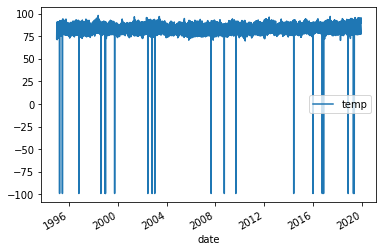

In [80]:
data[['temp']].plot()

In [13]:
data.describe()

,temp
count,8990.000000
mean,82.830400
std,11.377921
min,-99.000000
25%,79.300000
50%,83.800000
75%,87.000000
max,97.900000


In [14]:
train_split = round(len(data)*0.8)
train_split = 7200 
x_train=data[:train_split]
print("Training Set: "+str(len(x_train)))
x_test=data[train_split:]
print("Test Set: "+str(len(x_test)))

Training Set: 7200
Test Set: 1790


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [16]:
x_test

array([[-0.26242058],
       [ 0.23519777],
       [ 0.26390653],
       ...,
       [ 0.85722072],
       [ 0.72324655],
       [ 0.89549905]])

In [85]:
for i in range(len(x_train)-1):
    if x_train[i] < -5:
        x_train[i] = x_train[i-1]/2 + x_train[i+1]/2 
for i in range(len(x_test)-1):
    if x_test[i] < -5:
        x_test[i] = x_test[i-1]/2 + x_test[i+1]/2        

# Method 1

In [28]:
y_train=x_train[:,0]
y_test=x_test[:,0]

In [30]:
y_train

array([-0.97947551, -0.87426702, -0.96034669, ...,  0.1299959 ,
        0.1299959 ,  0.31171967])

In [33]:
from keras.preprocessing.sequence import TimeseriesGenerator
win_length=30
batch_size=32
num_features=1
train_generator=TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size=batch_size)

In [58]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 10, input_shape=(win_length,num_features)))
model.add(tf.keras.layers.LSTM(64,return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 21, 128)           1408      
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 64)            49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 83,905
Trainable params: 83,905
Non-trainable params: 0
_________________________________________________________________


In [69]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam())

history=model.fit_generator(train_generator,epochs=50,
                 validation_data=test_generator,
                 shuffle=False,
                 callbacks=[early_stopping])

Epoch 1/50
224/224 [==============================] - 2s 8ms/step - loss: 0.5857 - val_loss: 1.9355
Epoch 2/50
224/224 [==============================] - 1s 5ms/step - loss: 0.5851 - val_loss: 2.0669
Epoch 3/50
224/224 [==============================] - 1s 5ms/step - loss: 0.5880 - val_loss: 1.8937
Epoch 4/50
224/224 [==============================] - 1s 5ms/step - loss: 0.6047 - val_loss: 2.0316
Epoch 5/50
224/224 [==============================] - 1s 5ms/step - loss: 0.5901 - val_loss: 1.8921
Epoch 6/50
224/224 [==============================] - 1s 5ms/step - loss: 0.5851 - val_loss: 2.0354
Epoch 7/50
224/224 [==============================] - 1s 5ms/step - loss: 0.5885 - val_loss: 2.0568


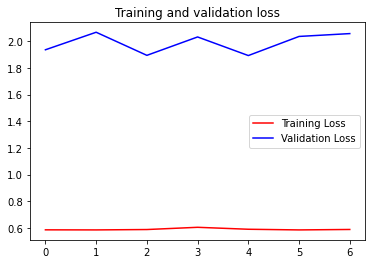

In [70]:
import matplotlib.pyplot as plt

loss = history.history['loss']# Your Code Here
val_loss = history.history['val_loss']# Your Code Here

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [71]:
model.evaluate_generator(test_generator,verbose=0)

2.0567779541015625

In [72]:
predictions=model.predict(test_generator)
predictions.shape

(1768, 1)

In [73]:
df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
rev_trans=sc.inverse_transform(df_pred)
df_final=data[predictions.shape[0]*-1:]
df_final['temp_pred']=rev_trans[:,0]

In [74]:
df_final

,temp,temp_pred
date,,
2014-10-10,85.7,83.786850
2014-11-10,86.2,84.482574
2014-12-10,87.3,85.352989
2014-10-13,86.9,86.508377
2014-10-14,86.8,86.304787
...,...,...
2019-07-08,89.4,88.865097
2019-08-08,91.1,89.840454
2019-09-08,91.6,91.010681


<AxesSubplot:xlabel='date'>

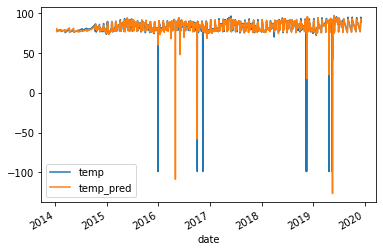

In [75]:
import matplotlib.pyplot as plt
df_final[['temp','temp_pred']].plot()

# Method 2

In [17]:
len(x_train)

7200

In [103]:
ws = 10

In [104]:
X = np.zeros((len(x_train)-ws-1,ws),dtype='float64')

In [105]:
Y = np.zeros((len(x_train)-ws-1))

In [106]:
for i in range(len(x_train)-ws-1):
    for j in range(ws):
        X[i][j] = x_train[i+j]
    Y[i] = x_train[i+ws]    

In [107]:
X.shape

(7189, 10)

In [108]:
X = tf.expand_dims(X,axis=-1)

In [109]:
Y.shape

(7189,)

In [110]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 10, input_shape=(ws,1)))
model.add(tf.keras.layers.LSTM(64,input_shape=(ws,1),return_sequences=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 128)            1408      
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 63,683
Trainable params: 63,683
Non-trainable params: 0
__________________________________________________

In [111]:
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam())

history=model.fit(X,Y,epochs=40,shuffle=False)

Epoch 1/40
225/225 [==============================] - 1s 4ms/step - loss: 0.1307
Epoch 2/40
225/225 [==============================] - 1s 4ms/step - loss: 0.1016
Epoch 3/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0965
Epoch 4/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0871
Epoch 5/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0797
Epoch 6/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0771
Epoch 7/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0693
Epoch 8/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0769
Epoch 9/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0804
Epoch 10/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0774
Epoch 11/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0740
Epoch 12/40
225/225 [==============================] - 1s 4ms/step - loss: 0.0692
Epoch 13/40
225/225 [====

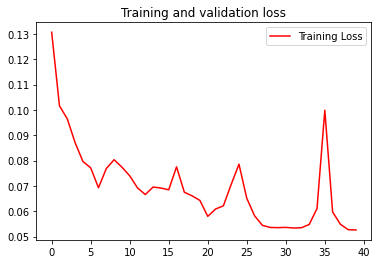

In [112]:
import matplotlib.pyplot as plt

loss = history.history['loss']# Your Code Here
# val_loss = history.history['val_loss']# Your Code Here

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
X_test = np.zeros((len(x_test)-ws-1,ws),dtype='float64')
Y_test = np.zeros((len(x_test)-ws-1))
for i in range(len(x_test)-ws-1):
    for j in range(ws):
        X_test[i][j] = x_test[i+j]
    Y_test[i] = x_test[i+ws]  
X_test = tf.expand_dims(X_test,axis=-1)    

In [114]:
X.shape

TensorShape([7189, 10, 1])

In [115]:
model.evaluate(np.asarray(X_test), Y_test)

56/56 [==============================] - 0s 2ms/step - loss: 0.1849


0.1848965883255005

In [116]:
Y_pred = model.predict(X_test)

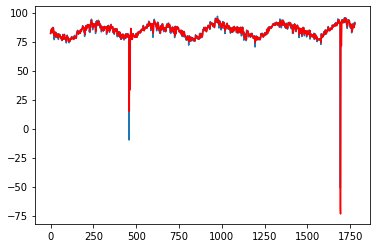

In [117]:
plt.plot(sc.inverse_transform(Y_test))
plt.plot(sc.inverse_transform(Y_pred),'red')

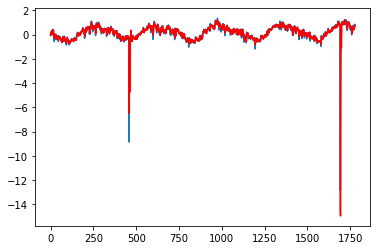

In [120]:
plt.plot((Y_test))
plt.plot((Y_pred),'red')

Validation with 2 week data 

In [124]:
val_data = pd.read_csv('data/2weekdata.csv')

In [125]:
val_data

,timestamp,Chennai Temperature [2 m elevation corrected],Chennai Relative Humidity [2 m],Chennai Wind Speed [10 m],Chennai Wind Direction [10 m],Chennai Mean Sea Level Pressure [MSL]
0,20201227T0000,72.331160,86.0,14.843180,14.036240,1012.8
1,20201227T0100,71.179150,89.0,13.722565,4.513962,1011.9
2,20201227T0200,69.793160,91.0,12.646200,355.100900,1011.6
3,20201227T0300,68.119156,92.0,11.841756,340.463350,1011.4
4,20201227T0400,66.391160,93.0,11.486200,327.804260,1011.9
...,...,...,...,...,...,...
355,20210110T1900,78.955154,82.0,19.453327,38.990982,1009.9
356,20210110T2000,78.829160,82.0,18.584509,45.784805,1010.6
357,20210110T2100,78.667160,83.0,18.000000,53.130096,1011.2
358,20210110T2200,78.559160,84.0,17.208603,52.650635,1011.1


In [129]:
val_data.columns=['time', 'temp','humidity', 'wind speed','dir','pres']

In [131]:
val_data = val_data[['time','temp']]

In [134]:
val_data['time']=pd.to_datetime(val_data['time'])

In [135]:
val_data

,time,temp
0,2020-12-27 00:00:00,72.331160
1,2020-12-27 01:00:00,71.179150
2,2020-12-27 02:00:00,69.793160
3,2020-12-27 03:00:00,68.119156
4,2020-12-27 04:00:00,66.391160
...,...,...
355,2021-01-10 19:00:00,78.955154
356,2021-01-10 20:00:00,78.829160
357,2021-01-10 21:00:00,78.667160
358,2021-01-10 22:00:00,78.559160


In [136]:
val_data.set_index('time')

,temp
time,
2020-12-27 00:00:00,72.331160
2020-12-27 01:00:00,71.179150
2020-12-27 02:00:00,69.793160
2020-12-27 03:00:00,68.119156
2020-12-27 04:00:00,66.391160
...,...
2021-01-10 19:00:00,78.955154
2021-01-10 20:00:00,78.829160
2021-01-10 21:00:00,78.667160


<AxesSubplot:>

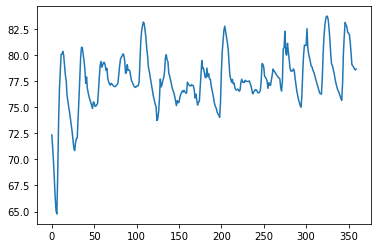

In [137]:
val_data['temp'].plot()

In [140]:
x_val = sc.transform(np.array(val_data['temp']).reshape(-1,1))

In [143]:
X_val = np.zeros((len(x_val)-ws-1,ws),dtype='float64')
Y_val = np.zeros((len(x_val)-ws-1))
for i in range(len(x_val)-ws-1):
    for j in range(ws):
        X_val[i][j] = x_val[i+j]
    Y_val[i] = x_val[i+ws]  
X_val = tf.expand_dims(X_val,axis=-1)    

In [144]:
model.evaluate(X_val, Y_val)

11/11 [==============================] - 0s 3ms/step - loss: 0.0103


0.010343844071030617

In [146]:
val_pred = model.predict(X_val)

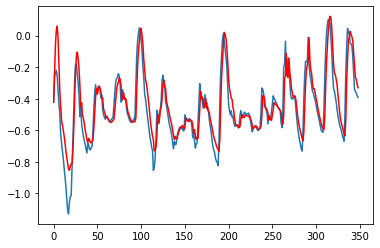

In [148]:
plt.plot(Y_val)
plt.plot(val_pred,'red')